In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from typing import NamedTuple

# Environnement Taxi
env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n

# Montecarlo

In [27]:
# Paramètres Monte Carlo optimisés
gamma = 0.95  # Pondération plus faible pour ne pas trop considérer les récompenses futures
epsilon = 1.0  # Exploration maximale au départ
epsilon_min = 0.01  # Valeur minimale d'exploration
epsilon_decay = 0.9995  # Décroissance plus lente pour plus d'exploration
num_episodes = 2000  # Garder les 2000 épisodes
max_steps = 200  # Limite du nombre d'actions par épisode

# Initialisation des variables
Q = np.zeros((n_states, n_actions))  # Q-table initiale
returns_sum = {}
returns_count = {}
success_rates = []
successful_episodes = 0
best_success_rate = 0

# Choix d'action epsilon-greedy
def choose_action(state, epsilon):
    return np.random.randint(n_actions) if np.random.rand() < epsilon else np.argmax(Q[state])

# Générer un épisode
def generate_episode(epsilon):
    episode = []
    state, _ = env.reset()
    for _ in range(max_steps):
        action = choose_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
            return episode, reward == 20  # Réussi si la récompense est 20
    return episode, False

# Entraînement avec Monte Carlo First-Visit
for episode_idx in range(1, num_episodes + 1):
    episode, success = generate_episode(epsilon)
    if success:
        successful_episodes += 1

    # Mise à jour de la Q-table avec First-Visit Monte Carlo
    G = 0
    visited = set()
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = reward + gamma * G
        if (state, action) not in visited:
            visited.add((state, action))
            returns_sum[(state, action)] = returns_sum.get((state, action), 0) + G
            returns_count[(state, action)] = returns_count.get((state, action), 0) + 1
            Q[state, action] = returns_sum[(state, action)] / returns_count[(state, action)]  # Mise à jour de la Q-table

    # Mise à jour de epsilon pour favoriser l'exploitation
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Évaluer tous les 100 épisodes
    if episode_idx % 100 == 0:
        rate = (successful_episodes / episode_idx) * 100
        success_rates.append(rate)

        print(f"📊 Épisode {episode_idx:>5} | Taux de réussite: {rate:>5.2f}%")

        # Si meilleure performance trouvée
        if rate > best_success_rate:
            best_success_rate = rate

📊 Épisode   100 | Taux de réussite:  4.00%
📊 Épisode   200 | Taux de réussite:  4.50%
📊 Épisode   300 | Taux de réussite:  8.67%
📊 Épisode   400 | Taux de réussite: 10.50%
📊 Épisode   500 | Taux de réussite: 14.20%
📊 Épisode   600 | Taux de réussite: 17.67%
📊 Épisode   700 | Taux de réussite: 20.43%
📊 Épisode   800 | Taux de réussite: 23.75%
📊 Épisode   900 | Taux de réussite: 26.78%
📊 Épisode  1000 | Taux de réussite: 29.20%
📊 Épisode  1100 | Taux de réussite: 30.18%
📊 Épisode  1200 | Taux de réussite: 31.75%
📊 Épisode  1300 | Taux de réussite: 33.38%
📊 Épisode  1400 | Taux de réussite: 33.57%
📊 Épisode  1500 | Taux de réussite: 34.80%
📊 Épisode  1600 | Taux de réussite: 35.00%
📊 Épisode  1700 | Taux de réussite: 35.65%
📊 Épisode  1800 | Taux de réussite: 36.61%
📊 Épisode  1900 | Taux de réussite: 36.89%
📊 Épisode  2000 | Taux de réussite: 37.40%


# Deep Q-Learning

In [28]:
# Configuration des seeds pour la reproductibilité
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

config = {
    "num_episodes_deep": 700,
    "epsilon": 1.0,
    "epsilon_decay": 0.0001,
    "learning_rate": 0.1,
    "discount_factor": 0.99
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")


class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.network(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


def train_deep(env, config):
    # Initialisation des réseaux de neurones
    policy_net = DQN(env.observation_space.n, env.action_space.n).to(device)  # Réseau principal
    target_net = DQN(env.observation_space.n, env.action_space.n).to(device)  # Réseau cible
    target_net.load_state_dict(policy_net.state_dict())  # Copie des poids initiaux

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)  # Optimiseur
    memory = ReplayBuffer(10000)  # Mémoire pour stocker les expériences
    batch_size = 64  # Taille des batchs d'apprentissage

    rewards_per_episode = np.zeros(config["num_episodes_deep"])
    success_rate = []
    success_window = []
    epsilon = config["epsilon"]  # Probabilité d'exploration

    for episode in range(config["num_episodes_deep"]):
        state = env.reset()[0]  # Reset de l'environnement
        terminated = False
        truncated = False
        episode_reward = 0
        episode_success = False

        # Boucle d'un épisode
        while not terminated and not truncated:
            # Conversion de l'état en tensor one-hot
            state_tensor = torch.zeros(env.observation_space.n)
            state_tensor[state] = 1
            state_tensor = state_tensor.to(device)

            # Sélection de l'action (exploration ou exploitation)
            if random.random() < epsilon:  # Exploration
                action = env.action_space.sample()
            else:  # Exploitation
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()

            # Exécution de l'action
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if reward > 0:
                episode_success = True

            # Préparation du prochain état
            next_state_tensor = torch.zeros(env.observation_space.n)
            next_state_tensor[next_state] = 1

            # Stockage de l'expérience dans la mémoire
            memory.push(state_tensor, action, reward, next_state_tensor, terminated)

            # Apprentissage si assez d'expériences stockées
            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Préparation des tensors
                states = torch.stack(states).to(device)
                actions = torch.tensor(actions).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                next_states = torch.stack(next_states).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                # Calcul des Q-values actuelles et cibles
                current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q_values = target_net(next_states).max(1)[0].detach()
                target_q_values = rewards + (1 - dones) * config["discount_factor"] * next_q_values

                # Optimisation
                loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state

        # Mise à jour du réseau cible périodiquement
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Enregistrement des statistiques
        rewards_per_episode[episode] = episode_reward
        success_window.append(1 if episode_success else 0)

        if success_window:
            if len(success_window) > 100:
                success_window.pop(0)
            current_success_rate = sum(success_window) / len(success_window) * 100
            success_rate.append(current_success_rate)
        else:
            success_rate.append(0)

        # Décroissance du epsilon
        epsilon = max(epsilon * 0.999, 0.01)

        # Affichage périodique des performances
        if (episode + 1) % 100 == 0:
            avg_success = sum(success_window) / len(success_window) * 100
            print(f"Deep Q-Learning - Épisode {episode + 1}, Taux de réussite: {avg_success:.2f}%")

    return policy_net, rewards_per_episode, success_rate


def evaluate_deep(env, policy_net, num_episodes=100):
    """
    Évalue les performances du Deep Q-learning
    """
    total_rewards = []

    for _ in range(num_episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        episode_reward = 0

        while not terminated and not truncated:
            state_tensor = torch.zeros(env.observation_space.n)
            state_tensor[state] = 1
            state_tensor = state_tensor.to(device)

            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()

            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Évaluation sur {num_episodes} épisodes:")
    print(f"Récompense moyenne: {mean_reward:.2f} ± {std_reward:.2f}")

    return mean_reward


print("\nEntraînement du Deep Q-learning...")
deep_q_net, deep_rewards, deep_success_rate = train_deep(env, config)

Utilisation de : cpu

Entraînement du Deep Q-learning...
Deep Q-Learning - Épisode 100, Taux de réussite: 8.00%
Deep Q-Learning - Épisode 200, Taux de réussite: 27.00%
Deep Q-Learning - Épisode 300, Taux de réussite: 51.00%
Deep Q-Learning - Épisode 400, Taux de réussite: 67.00%
Deep Q-Learning - Épisode 500, Taux de réussite: 96.00%
Deep Q-Learning - Épisode 600, Taux de réussite: 100.00%
Deep Q-Learning - Épisode 700, Taux de réussite: 100.00%


# Q-Learning

In [29]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    n_runs: int  # Number of runs
    epsilon: float  # Exploration probability
    epsilon_decay: float  # Decay epsilon
    epsilon_min: float  # Epsilon minimum value
    alpha: float  # Learning rate
    gamma: float  # Discounting rate
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    seed: int  # Define a seed so that we get reproducible results


params = Params(
    total_episodes=500,
    n_runs=3,
    alpha=0.5,
    gamma=0.95,
    epsilon=1,
    epsilon_decay=0.005,
    epsilon_min=0.01,
    action_size=None,
    state_size=None,
    seed=123,
)

# Set the seed
rng = np.random.default_rng(params.seed)
env = gym.make('Taxi-v3', render_mode="rgb_array")
# env.metadata['render_fps']=120

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, alpha, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
                reward
                + self.gamma * np.max(self.qtable[new_state, :])
                - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.alpha * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon, epsilon_min, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)
        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()
            decision_type = "exploration"
        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # Find the indices where the Q-value equals the maximum value
            # Choose a random action from the indices where the Q-value is maximum
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
            decision_type = "exploitation"
        return action, decision_type

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon - self.epsilon_decay, self.epsilon_min)


class Tester:
    def pick_action(self, state, qtable):
        max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
        action = rng.choice(max_ids)
        return action


learner = Qlearning(
    alpha=params.alpha,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)


def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    wins = np.zeros((params.total_episodes, params.n_runs))
    truncated_episodes = np.zeros((params.total_episodes, params.n_runs))
    explorations = np.zeros(params.n_runs)
    exploitations = np.zeros(params.n_runs)

    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        explorer = EpsilonGreedy(
            epsilon=params.epsilon,
            epsilon_decay=params.epsilon_decay,
            epsilon_min=params.epsilon_min,
        )

        for episode in tqdm(
                episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):

            state = env.reset(seed=params.seed)[0]
            done = False
            total_rewards = 0  # +20 delivering passenger else -10 illegal action else -1
            total_steps = 0

            while not done:
                action, decision_type = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                explorations[run] += 1 if decision_type == "exploration" else 0
                exploitations[run] += 1 if decision_type == "exploitation" else 0

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                if action == 5:
                    print('Dropped passager')
                    print("terminated :" + str(terminated))
                    print("truncated :" + str(truncated))

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_steps += 1
                total_rewards += reward

                # Our new state is state
                state = new_state

            truncated_episodes[episode, run] = 1 if truncated else 0
            wins[episode, run] = 1 if terminated and reward == 20 else 0

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = total_steps

            explorer.decay_epsilon()

        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions, wins, explorations, exploitations, truncated_episodes


rewards, steps, episodes, qtables, all_states, all_actions, wins, explorations, exploitations, truncated_episodes = run_env()

Action size: 6
State size: 500


Run 0/3 - Episodes:  26%|██▌       | 128/500 [00:00<00:00, 685.61it/s]

Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped pass

Run 0/3 - Episodes:  82%|████████▏ | 410/500 [00:00<00:00, 1652.47it/s]

Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminate

Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :Tr

Run 1/3 - Episodes:   6%|▌         | 29/500 [00:00<00:01, 288.86it/s]

Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped pass

Run 1/3 - Episodes:  21%|██        | 103/500 [00:00<00:00, 552.78it/s]

Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager

Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :Tr

Run 2/3 - Episodes:   6%|▋         | 32/500 [00:00<00:01, 314.74it/s]

Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped pass

Run 2/3 - Episodes:  24%|██▍       | 119/500 [00:00<00:00, 638.97it/s]

Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped pass

Run 2/3 - Episodes:  78%|███████▊  | 392/500 [00:00<00:00, 1588.31it/s]

Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
terminated :False
truncated :False
Dropped passager
te

Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :True
truncated :False
Dropped passager
terminated :Tr

In [30]:
# Extraction des performances Monte Carlo
monte_carlo_results = {
    "episodes": np.arange(100, num_episodes + 1, 100),
    "success_rate": success_rates
}

# Extraction des performances Deep Q-Learning
deep_q_learning_results = {
    "episodes": np.arange(1, config["num_episodes_deep"] + 1),
    "success_rate": deep_success_rate
}

# Extraction des performances Q-Learning
q_learning_results = {
    "episodes": np.arange(params.total_episodes),
    "success_rate": wins.mean(axis=1) * 100  # Moyenne des victoires sur les runs
}

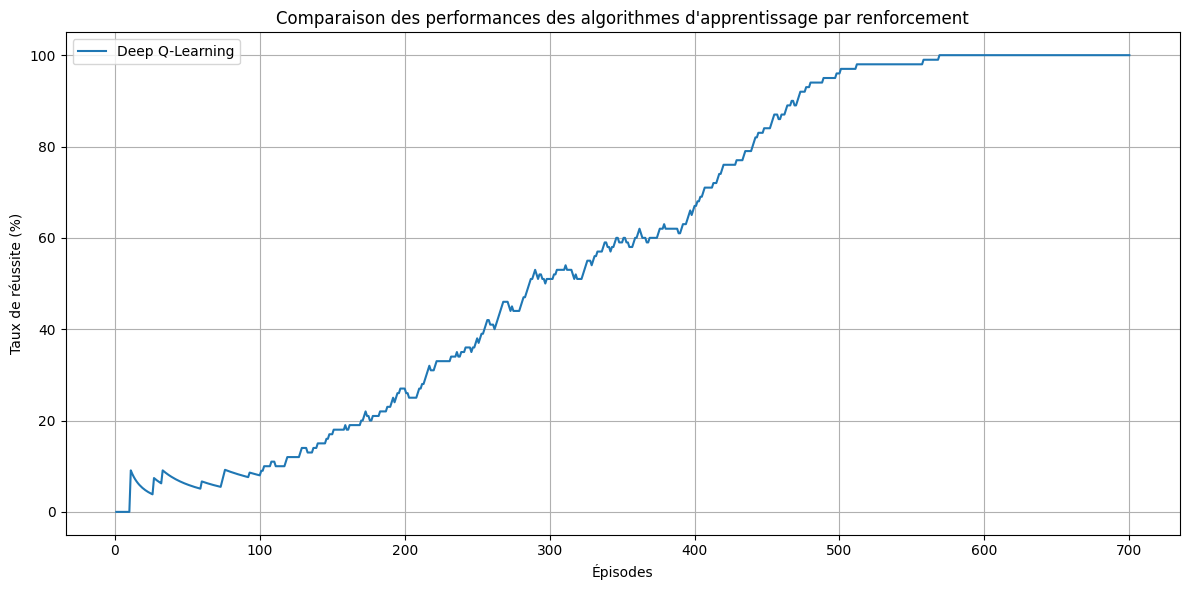

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# plt.plot(monte_carlo_results["episodes"], monte_carlo_results["success_rate"], label="Monte Carlo")
plt.plot(deep_q_learning_results["episodes"], deep_q_learning_results["success_rate"], label="Deep Q-Learning")
# plt.plot(q_learning_results["episodes"], q_learning_results["success_rate"], label="Q-Learning")

plt.xlabel("Épisodes")
plt.ylabel("Taux de réussite (%)")
plt.title("Comparaison des performances des algorithmes d'apprentissage par renforcement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()